In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# from Models.dataset import load_train_data, load_test_data


In [3]:
def load_train_data(img_size):
    """
    This function loads a dataset of images from a specified path, resizes the images, 
    and stores them in a pandas DataFrame along with their respective classes.

    The images are categorized into four classes: 'MildDemented', 'ModerateDemented', 
    'NonDemented', and 'VeryMildDemented'. The function iterates through each class, 
    opens and resizes the images, and appends them to a dictionary along with their class.

    The dictionary is then converted into a pandas DataFrame and returned.

    Returns:
        df_train (pd.DataFrame): A DataFrame containing the resized images and their classes.
    """
    
    df_train=[] # create a dictionary to store the dataset
    labels=[] # create a list to store the labels

    """# create dataset from the image folder"""

    classes=['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
    train_path=''

    for i in classes:
        if i=='MildDemented':
            train_path='../Dataset/train/MildDemented/mildDem'
        elif i=='ModerateDemented':
            train_path='../Dataset/train/ModerateDemented/moderateDem'
        elif i=='NonDemented':
            train_path='../Dataset/train/NonDemented/nonDem'
        else:
            train_path='../Dataset/train/VeryMildDemented/veryMildDem'
        for j in range(100000):
            try:
                img=cv2.imread(f'{train_path}{j}.jpg',cv2.IMREAD_GRAYSCALE)
                df_train.append(cv2.resize(img,(img_size,img_size)).reshape(img_size*img_size))
                labels.append(i)

            except:
                break

    """# save Dataset into a pandas Dataframe"""
    return np.array(df_train),labels

In [4]:
img_size=100
df_train,labels=load_train_data(img_size)

In [5]:
print(df_train.shape)
# df_train.head()
df_train=pd.DataFrame(df_train)
df_train['class']=labels

(5121, 10000)


In [6]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MildDemented
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MildDemented
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MildDemented
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MildDemented
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,MildDemented


In [7]:
X,Y=df_train.iloc[:,:-1].values,df_train.iloc[:,-1]
X=X.reshape(X.shape[0],img_size,img_size,1)



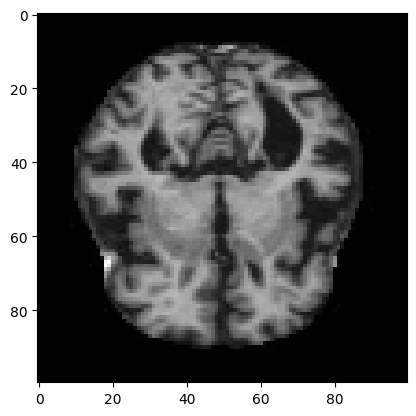

In [8]:
plt.imshow(X[0],cmap='gray')

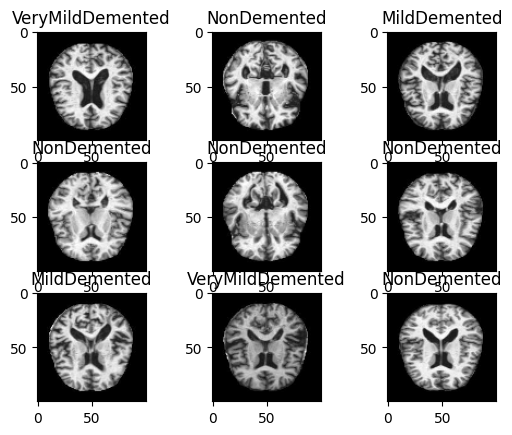

In [9]:
import random
for i in range(0,9):
    j=random.randint(0,X.shape[0])
    plt.subplot(330+1+i)
    plt.imshow(X[j].reshape(img_size,img_size),cmap=plt.get_cmap('gray'))
    plt.title(Y[j])

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [11]:
Y_train
# encode the target variable
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
Y_train=le.fit_transform(Y_train)
Y_test=le.transform(Y_test)


In [12]:
from keras.utils import to_categorical
Y_train=to_categorical(Y_train)
Y_test=to_categorical(Y_test)

# Inception Network Layer

In [80]:
# from keras.models import Model
from keras.layers import Conv2D, concatenate
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.layers import Layer

class Inception_Conv2D(Layer):
    def __init__(self, prev_shape):
        super(Inception_Conv2D, self).__init__()
        self.prev_shape = prev_shape
        self.conv1_1 = Conv2D(128, (1, 1), padding='same', activation='relu')
        self.conv1_2 = Conv2D(32, (3, 3), padding='same', activation='relu')
        self.conv2_1 = Conv2D(128, (1, 1), padding='same', activation='relu')
        self.conv2_2 = Conv2D(32, (5, 5), padding='same', activation='relu')
        self.conv3 = Conv2D(32, (1, 1), padding='same', activation='relu')
        self.pool4_1 = MaxPooling2D(3,1, padding='same')
        self.conv4_2= Conv2D(32, (1, 1), padding='same', activation='relu')

    def call(self, inputs):
        conv1_1 = self.conv1_1(inputs)
        conv1_2 = self.conv1_2(conv1_1)
        conv2_1 = self.conv2_1(inputs)
        conv2_2 = self.conv2_2(conv2_1)
        conv3 = self.conv3(inputs)
        pool4_1 = self.pool4_1(inputs)
        conv4_2= self.conv4_2(pool4_1)
        return concatenate([conv1_2, conv2_2, conv3, conv4_2])



# Inception model

In [81]:
from keras.models import Sequential

model_inception=Sequential()
model_inception.add(Inception_Conv2D((img_size,img_size,1))) #c=256
model_inception.add(BatchNormalization())
model_inception.add(MaxPooling2D(2,2)) #f=2,p=0,s=2,c=256
model_inception.add(Dropout(0.2))

# model_inception.add(Inception_Conv2D((img_size//2,img_size//2,256))) #c=256
# model_inception.add(BatchNormalization())
# model_inception.add(MaxPooling2D(2,2)) #f=2,p=0,s=2,c=256
# model_inception.add(Dropout(0.2))

# model_inception.add(Inception_Conv2D((img_size//4,img_size//4,256))) #c=256
# model_inception.add(BatchNormalization())
# model_inception.add(MaxPooling2D(2,2)) #f=2,p=0,s=2,c=256


model_inception.add(Flatten())
model_inception.add(Dense(32,activation='relu'))
model_inception.add(Dropout(0.4))
model_inception.add(Dense(4,activation='softmax'))
model_inception.compile(optimizer=Adam(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

model_inception.build((None,img_size,img_size,1))



In [83]:

model_inception.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception__conv2d_45 (Incep  (None, 100, 100, 128)    139968    
 tion_Conv2D)                                                    
                                                                 
 batch_normalization_45 (Bat  (None, 100, 100, 128)    512       
 chNormalization)                                                
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 50, 50, 128)      0         
 g2D)                                                            
                                                                 
 dropout_40 (Dropout)        (None, 50, 50, 128)       0         
                                                                 
 flatten_25 (Flatten)        (None, 320000)            0         
                                                     

In [ ]:
model_inception.fit(X_train,Y_train,epochs=10,batch_size=128,validation_data=(X_test,Y_test))

In [ ]:
y_pred=model_inception.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
print('predicted labels are:')
print(le.inverse_transform(y_pred))
print(model_inception.evaluate(X_test,Y_test))